# **Clustering Geolocation Data**
### The dataset given contains taxi rank locations. We want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.

In [38]:
#Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import hdbscan
import folium
import re
from tqdm import tqdm
from kneed import KneeLocator

# 1. Exploratory Data Analysis

In [39]:
#Load the data
df = pd.read_csv('../input/taxi_data.csv')

In [40]:
#Check the contents of the data
print('-----First five lines of the data-----')
print(df.head())
print("")
print('-----Data Shape-----')
print(df.shape)
print("")
print('-----Information-----')
print(df.info())
print("")
print('-----Check for correctness of data-----')
print(df.describe())

-----First five lines of the data-----
        LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

-----Data Shape-----
(838, 3)

-----Information-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LON     837 non-null    float64
 1   LAT     837 non-null    float64
 2   NAME    837 non-null    object 
dtypes: float64(2), object(1)
memory usage: 19.8+ KB
None

-----Check for correctness of data-----
              LON         LAT
count  837.000000  837.000000
mean    28.066357  -26.145757
std      0.216721    0.259974
min     27.284510  -26.712430
25%     27.890500  -26.301480
50%     28.048840  -26.1992

### The data is simple, it only contains 3 features. The min and max shows that there is no incorrect data.

### Let us check if there are duplicates and null values.

In [41]:
print('Duplicates: ',df.duplicated(subset=['LON','LAT']).values.sum())
print('Null values: ',df.isna().values.sum())

Duplicates:  14
Null values:  3


In [42]:
#Remove duplicates and null values
print('Before removal of duplicates and null values: ',df.shape)
df.drop_duplicates(subset=['LON','LAT'],keep='first',inplace=True)
df.dropna(inplace=True)
print('After removal of duplicates and null values: ',df.shape)

Before removal of duplicates and null values:  (838, 3)
After removal of duplicates and null values:  (823, 3)


In [43]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

# 2. Data Visualization

In [44]:
#Let us visualize the geographical data using folium
X = df[['LAT','LON']].values
map = folium.Map(location=[X[:,0].mean(),X[:,1].mean()],tiles='Stamen Toner',zoom_start=10)

In [45]:
#Let us fill-in this map with the datapoints
for _,row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT,row.LON],
        radius=5,
        popup=re.sub(r'\W+',' ',row.NAME),
        fill=True
    ).add_to(map)
#Remember to remove non-word characters in popup since this result in a broken map 
title = '''<h3 align="center" style="font-size:30px"><b>Given Data</b></h3>'''
map.get_root().html.add_child(folium.Element(title))
map

# 3. KMeans Clustering
### We first use the simplest clustering method which is the KMeans algorithm.
### First let us find the best number of clusters using Elbow method.

100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


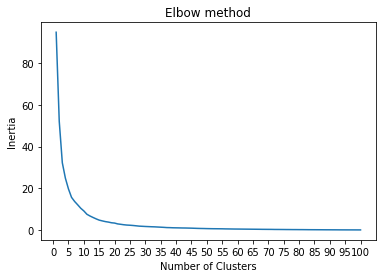

In [46]:
inertia=[]
for i in tqdm(range(1,101)):
    kmeans = KMeans(n_clusters=i,random_state=0).fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1,101),inertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(0,101,5))
plt.show()

### There is no obvious elbow point using the elbow method. Let us try to check using the silhouette value.

In [47]:
score=-1
k=0
for i in tqdm(range(2,101)):
    kmeans = KMeans(n_clusters=i,random_state=0).fit(X)
    score2 = silhouette_score(X,kmeans.predict(X))
    if score2>score:
        score=score2
        k=i
print('The best number of clusters based on silhouette score is {} with a score of {}.'.format(k,score))

100%|██████████| 99/99 [00:29<00:00,  3.39it/s]

The best number of clusters based on silhouette score is 99 with a score of 0.6994533421627726.


### Since the elbow method and silhouette score fails in giving us the best number of clusters, this may mean that KMeans algorithm is not sufficient to use.
### For the purpose of finding the elbow point, we use the kneed library. 

In [48]:
elbow_point = KneeLocator(range(1,101),inertia,curve='convex',direction='decreasing')
print(elbow_point.knee)

11


### So let us use n_clusters=12 in the KMeans algorithm.

In [49]:
kmeans = KMeans(n_clusters=12,random_state=0).fit(X)
kmeans_prediction = kmeans.predict(X)
df['Cluster_KMeans'] = kmeans_prediction
print(df.head())

        LON       LAT                          NAME  Cluster_KMeans
0  28.17858 -25.73882         11th Street Taxi Rank              10
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank              10
2  27.83239 -26.53722          Adams Road Taxi Rank               0
3  28.12514 -26.26666  Alberton City Mall Taxi Rank               8
4  28.10144 -26.10567      Alexandra Main Taxi Rank               4


In [50]:
#Visualize the KMeans result

#First create an array of color schemes
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 
          'olive', 'goldenrod', 'lightcyan', 'navy','springgreen','midnightblue',
         'red','brown','limegreen','lime','pink','orchid','crimson','m']*10
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_KMeans'] = vectorizer(kmeans_prediction)

def create_map(cluster_column, colors_column, title):
    map = folium.Map(location=[X[:,0].mean(),X[:,1].mean()],tiles='Stamen Toner',zoom_start=8.5)
    for _,row in df.iterrows():
        folium.CircleMarker(
            location=[row.LAT,row.LON],
            radius=5,
            popup=row[cluster_column],
            fill=True,
            color=row[colors_column],
            fill_color=row[colors_column],
        ).add_to(map)

    print(title)
    return map

create_map('Cluster_KMeans','Colors_KMeans','KMeans Clustering')

KMeans Clustering


In [51]:
print('Number of clusters: 12')

print('Silhouette score: {}'.format(round(silhouette_score(X,kmeans_prediction),2)))

Number of clusters: 12
Silhouette score: 0.49


# 4. DBSCAN
### DBSCAN is another clustering algorithm which I find appropriate to use in this problem since we are dealing with geographical data which can have varying cluster shape and density. This algorithm also excludes noise/outliers unlike KMeans which uses the whole dataset. 

### But before we proceed with DBSCAN calculation, we need to first find the most important parameter, epsilon, which is the maximum distance between points to create a cluster. We can find this using the NearestNeighbors algorithm.

<Figure size 360x360 with 0 Axes>

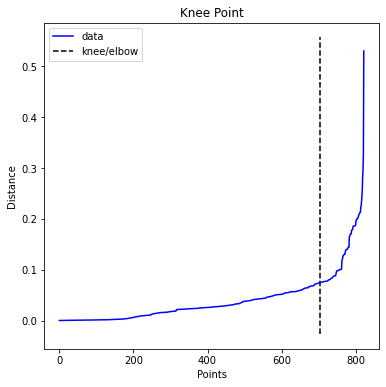

The elbow point is at around 0.075


In [52]:
# The eps is proportional to the expected number of neighbours, we can use the nearest neighbors to reach a fair estimation for eps.
# We still use the kneed library to get the elbow point.

nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
# We use the polynomial interp_method in this one to get a smooth line
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
print('The elbow point is at around {}'.format(round(distances[knee.knee],3)))

In [53]:
dbscan = DBSCAN(eps=0.075)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
df['Cluster_DBSCAN'] = dbscan_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_DBSCAN'] = vectorizer(dbscan_predictions)

In [54]:
create_map('Cluster_DBSCAN','Colors_DBSCAN','DBSCAN (eps=0.075)')

DBSCAN (eps=0.075)


In [55]:
print('Number of clusters found: {}'.format(len(np.unique(dbscan_predictions))))
print('Number of outliers found: {}'.format(len(dbscan_predictions[dbscan_predictions==-1])))

outliers=[(counter+2)*x if x==-1 else x for counter,x in enumerate(dbscan_predictions)]
print('Silhouette score ignoring outliers: {}'.format(silhouette_score(X[dbscan_predictions!=-1],
                                                                       dbscan_predictions[dbscan_predictions!=-1])))
print('Silhouette score with outliers as singletons: {}'.format(silhouette_score(X,outliers)))

Number of clusters found: 9
Number of outliers found: 29
Silhouette score ignoring outliers: 0.27896508422809835
Silhouette score with outliers as singletons: -0.1282188251997393


### The score using eps=0.075 which was derived using NearestNeighbor estimation is very low. Let us use another method to derive eps by checking the score at specified iterations.

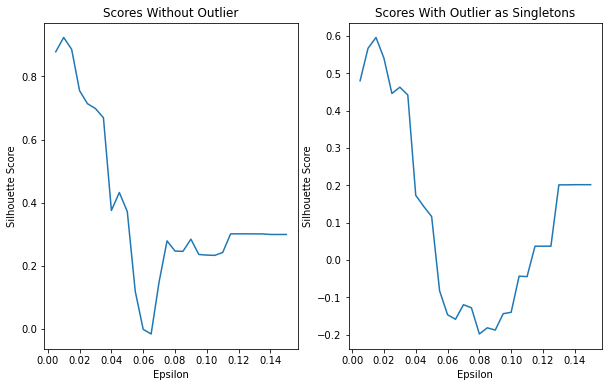

The best score 0.923 is attained at epsilon of 0.01


In [56]:
scores_no_outlier=[]
scores_with_outlier=[]
max_score=0
best_eps=0
for i in np.arange(0.15,0,-0.005):
    dbscan = DBSCAN(eps=i)
    dbscan.fit(X)
    dbscan_predictions = dbscan.labels_
    score_without_outlier=silhouette_score(X[dbscan_predictions!=-1], dbscan_predictions[dbscan_predictions!=-1])
    scores_no_outlier.append(score_without_outlier)
    outliers=[(counter+2)*x if x==-1 else x for counter,x in enumerate(dbscan_predictions)]
    scores_with_outlier.append(silhouette_score(X,outliers))
    
    if score_without_outlier>max_score:
        max_score = score_without_outlier
        best_eps = i
    
plt.figure(figsize=(10,6))    
plt.subplot(1,2,1)
plt.plot(np.arange(0.15,0,-0.005),scores_no_outlier)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Scores Without Outlier')

plt.subplot(1,2,2)
plt.plot(np.arange(0.15,0,-0.005),scores_with_outlier)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Scores With Outlier as Singletons')
plt.show()

print('The best score {} is attained at epsilon of {}'.format(round(max_score,3),round(best_eps,3)))

In [57]:
dbscan = DBSCAN(eps=0.01)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
df['Cluster_DBSCAN_Silhouette'] = dbscan_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_DBSCAN_Silhouette'] = vectorizer(dbscan_predictions)

create_map('Cluster_DBSCAN_Silhouette','Colors_DBSCAN_Silhouette','DBSCAN (eps=0.01)')

DBSCAN (eps=0.01)


In [58]:
print('Number of clusters found: {}'.format(len(np.unique(dbscan_predictions))))
print('Number of outliers found: {}'.format(len(dbscan_predictions[dbscan_predictions==-1])))

outliers=[(counter+2)*x if x==-1 else x for counter,x in enumerate(dbscan_predictions)]
print('Silhouette score ignoring outliers: {}'.format(silhouette_score(X[dbscan_predictions!=-1],
                                                                       dbscan_predictions[dbscan_predictions!=-1])))
print('Silhouette score with outliers as singletons: {}'.format(silhouette_score(X,outliers)))

Number of clusters found: 51
Number of outliers found: 289
Silhouette score ignoring outliers: 0.9232138256614868
Silhouette score with outliers as singletons: 0.5667489355530314


### We get a better score by estimating the eps value using the Silhouette plot. More clusters are identified as well as outliers.

# 5. HDBSCAN
### We use another clustering algorithm called HDBSCAN which extends DBSCAN by converting it into a hierarchical clustering algorithm. In addition to being better for data with varying density, it’s also faster than regular DBSCAN.

In [59]:
hdbscan_model = hdbscan.HDBSCAN(cluster_selection_epsilon=0.01)
hdbscan_predictions = hdbscan_model.fit_predict(X)

In [60]:
df['Cluster_HDBSCAN'] = hdbscan_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_HDBSCAN'] = vectorizer(hdbscan_predictions)

create_map('Cluster_HDBSCAN','Colors_HDBSCAN','HDBSCAN')

HDBSCAN


In [61]:
print('Number of clusters found: {}'.format(len(np.unique(hdbscan_predictions))))
print('Number of outliers found: {}'.format(len(hdbscan_predictions[hdbscan_predictions==-1])))

outliers=[(counter+2)*x if x==-1 else x for counter,x in enumerate(hdbscan_predictions)]
print('Silhouette score ignoring outliers: {}'.format(silhouette_score(X[hdbscan_predictions!=-1],
                                                                       hdbscan_predictions[hdbscan_predictions!=-1])))
print('Silhouette score with outliers as singletons: {}'.format(silhouette_score(X,outliers)))

Number of clusters found: 62
Number of outliers found: 149
Silhouette score ignoring outliers: 0.8159861509699422
Silhouette score with outliers as singletons: 0.614901711294763


### With HDBSCAN, we formed more clusters and less outliers are present.

# 6. Taking care of the Outliers
### We can address the presence of outliers by using a hybrid algorithm, HDBSCAN + KNearestNeighbors. The idea here is we combine an unsupervised with supervised learning algorithm. Since we already have cluster groups obtained from HDBSCAN, we will classify the outliers using KNN.

In [62]:
# First we get our training and prediction data
X_train = df[df['Cluster_HDBSCAN']!=-1][['LON','LAT']]
y_train = df[df['Cluster_HDBSCAN']!=-1]['Cluster_HDBSCAN']

X_pred = df[df['Cluster_HDBSCAN']==-1][['LON','LAT']]

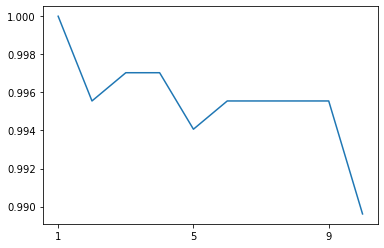

In [63]:
# Before we use the model, let us first check the best number of neighbors to use
scores=[]
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    scores.append(knn.score(X_train,y_train))

plt.plot(range(1,11),scores)
plt.xticks(np.arange(1,11,4))
plt.show()

### So it seems that we can use n_neighbors = 1

In [64]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

knn_predictions = knn.predict(X_pred)
df['Cluster_Hybrid'] = df['Cluster_HDBSCAN']
df.loc[df['Cluster_HDBSCAN']==-1,'Cluster_Hybrid'] = knn_predictions

vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['Colors_Hybrid'] = vectorizer(df['Cluster_Hybrid'].values)

create_map('Cluster_Hybrid','Colors_Hybrid','Hybrid (HDBSCAN + KNN)')

Hybrid (HDBSCAN + KNN)


In [65]:
print('Number of clusters found: {}'.format(len(np.unique(df['Cluster_Hybrid']))))
print('Silhouette score: {}'.format(round(silhouette_score(X,df['Cluster_Hybrid']),2)))

Number of clusters found: 61
Silhouette score: 0.58


# **7. Final Thoughts**

### In this problem we used different clustering techniques. We started with KMeans algorithm which is the simplest and fastest clustering algorithm. We showed that DBSCAN performs well on geographical data but selecting the epsilon value is critical. The HDBSCAN algorithm is better to use on data with varying density which is applicable here since taxi density is higher around the city and is less away from the city. 
### We should also remember that the Silhouette score with -1 as worst and 1 as best is only a guide and should not be taken as the absolute metric to say if the cluster is good or not. Such as the case with DBSCAN and HDBSCAN, although HDBSCAN has a bit lower Silhouette score, it was able to cluster more data and contains fewer outliers.
### Another thing to point out is that combination of unsupervised and supervised algorithm is possible to handle outliers in the data.